In [7]:
import os
import sys
import casadi as cd
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from Envs.pendulum import Pendulum_Env,Pendulum_Model
from Solvers.OCsolver import ocsolver_v2
from Solvers.Cutter import cutter_v2
from Solvers.MVEsolver import mvesolver
from utils.Correction import Correction_Agent
import numpy as np
from matplotlib import pyplot as plt

In [8]:
def pendulum_eval(gamma=0.1):
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=gamma
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-2,-2]) #-6
    ubs=np.array([2,2])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-1.0) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0.,0.])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                corr_num+=1
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:
                if np.linalg.norm(difference) < 0.02:
                    print("converged! Final Result: ",learned_theta)
                    termination_flag=True
                    break
                
                
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [9]:
theta_logs=[]
error_logs=[]
volume_logs=[]
lengths = []

In [ ]:
avg_lengths = []
std_lengths = []
for gamma in [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]:
    theta_logs=[]
    error_logs=[]
    volume_logs=[]
    lengths = []
    eval_cnt=0
    while eval_cnt<20:
        print('eval num',eval_cnt)
        try:
            tmp_theta_log,tmp_error_log,tmp_volume_log=pendulum_eval(gamma)
            print('length',len(tmp_theta_log))
            lengths.append(len(tmp_theta_log))
            theta_logs.append(tmp_theta_log)
            error_logs.append(tmp_error_log)
            volume_logs.append(tmp_volume_log)
            eval_cnt+=1
        except:
            print("error")

    avg_lengths.append(np.mean(lengths))
    std_lengths.append(np.std(lengths))

In [11]:
avg_lengths

[12.0, 11.4, 12.05, 12.75, 11.25, 12.5, 11.15, 11.6, 11.85, 12.65]

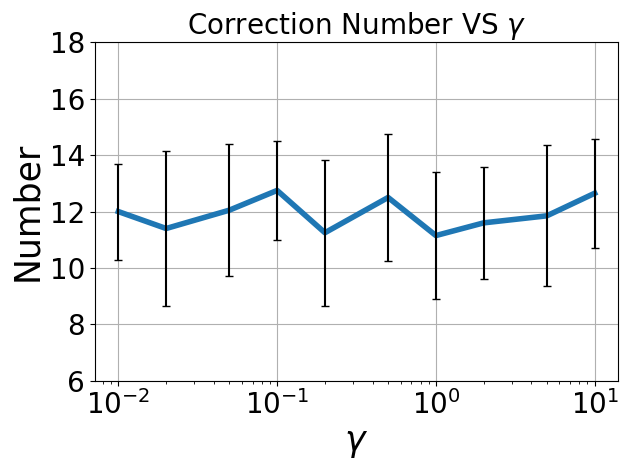

In [23]:
gamma_list = [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]
plt.figure()
plt.title("Correction Number VS $\gamma$",fontsize=20)
plt.grid()
plt.plot(gamma_list,avg_lengths,linewidth=4)
plt.errorbar(gamma_list, avg_lengths, yerr=std_lengths, capsize=3, fmt="none", ecolor = "black",markersize = 5)
plt.xscale('log')
plt.xlabel("$\gamma$",fontsize=25)
plt.ylabel("Number",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(6,18)
plt.tight_layout()
plt.savefig('../Data/ablation/gamma.jpg')
plt.show()
